# ADA - Final project
This notebook aims at giving technical explanations necessary to understand how the results given in the final report were found.

First off, the following commands allow you to retrieve the data necessary to run this notebook locally from the cluster used for this class.
1. Upload the files script.sh and script.py using the following command:  
```bash 
scp -r -p /path/to/script.py GASPAR@iccluster028.iccluster.epfl.ch:/home/GASPAR/script.py  
scp -r -p /path/to/script.sh GASPAR@iccluster028.iccluster.epfl.ch:/home/GASPAR/script.sh
```
2. Connect to the cluster using a second terminal and run the scripts:  
```bash 
ssh GASPAR@iccluster028.iccluster.epfl.ch  
sh script.sh script.py  
```
3. Store the output in the home folder:  
```bash 
hadoop fs -get /user/GASPAR/politics_2016_* file:///home/GASPAR
```
4. Download the data locally using the first terminal:  
```bash 
scp -r GASPAR@iccluster028.iccluster.epfl.ch:/home/GASPAR/politics_2016_* /local/path/to/folder
```

The retrieved dataset consists of several different features listed below:
* **author**: The username of the author of the comment.
* **author_flair_text**: Users can pick so-called *flairs* which are basically tags intended to briefly summarize the user.  They're different for each subreddit, and users can only pick one per subreddit.
* **body**: The content of the comment.
* **created_utc**: The date at which the comment was originally posted.
* **gilded**: Denotes if the comment received a gold. A gold is a form of gratification users can give one another. They're not common because gilding someone costs money.
* **id**: A unique ID that defines the comment.
* **link_id**: A unique ID that determines the post in which the comment was posted to.
* **parent_id**: A unique ID that determines to what the comment is responding to. If it starts with *t1*, the comment is a response to another comment. If it starts with *t3*, the comment is responding directly to the original post.
* **score**: The number of upvotes minus the number of downvotes the comment received.


## Imports

In [1]:
import nltk
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer

%matplotlib inline

## Loading data

In [2]:
DATA_PATH = 'data/'

In [3]:
states = pd.read_csv(DATA_PATH + 'states.csv')

In [4]:
politics_06 = pd.read_parquet(DATA_PATH + 'politics_2016_06/')
politics_07 = pd.read_parquet(DATA_PATH + 'politics_2016_07/')
politics_08 = pd.read_parquet(DATA_PATH + 'politics_2016_08/')
politics_09 = pd.read_parquet(DATA_PATH + 'politics_2016_09/')
politics_10 = pd.read_parquet(DATA_PATH + 'politics_2016_10/')
politics_11 = pd.read_parquet(DATA_PATH + 'politics_2016_11/')

## Cleaning data

Features are converted into appropriate format.  
Redundant data are removed as well.  
  
It is possible to retrieve if the comment was responding to a post or to another comment by matching *link_id* and *parent_id*.

In [6]:
# created_utc is converted to the datetime format
politics_06['created_utc'] = pd.to_datetime(politics_06['created_utc'], unit='s')
politics_07['created_utc'] = pd.to_datetime(politics_07['created_utc'], unit='s')
politics_08['created_utc'] = pd.to_datetime(politics_08['created_utc'], unit='s')
politics_09['created_utc'] = pd.to_datetime(politics_09['created_utc'], unit='s')
politics_10['created_utc'] = pd.to_datetime(politics_10['created_utc'], unit='s')
politics_11['created_utc'] = pd.to_datetime(politics_11['created_utc'], unit='s')

# author_flair_text is converted to a category
politics_06['author_flair_text'] = politics_06['author_flair_text'].astype('category')
politics_07['author_flair_text'] = politics_07['author_flair_text'].astype('category')
politics_08['author_flair_text'] = politics_08['author_flair_text'].astype('category')
politics_09['author_flair_text'] = politics_09['author_flair_text'].astype('category')
politics_10['author_flair_text'] = politics_10['author_flair_text'].astype('category')
politics_11['author_flair_text'] = politics_11['author_flair_text'].astype('category')

# remove unnecessary information in link_id and parent_id
politics_06['link_id'] = politics_06['link_id'].str.slice(3)
politics_07['link_id'] = politics_07['link_id'].str.slice(3)
politics_08['link_id'] = politics_08['link_id'].str.slice(3)
politics_09['link_id'] = politics_09['link_id'].str.slice(3)
politics_10['link_id'] = politics_10['link_id'].str.slice(3)
politics_11['link_id'] = politics_11['link_id'].str.slice(3)
politics_06['parent_id'] = politics_06['parent_id'].str.slice(3)
politics_07['parent_id'] = politics_07['parent_id'].str.slice(3)
politics_08['parent_id'] = politics_08['parent_id'].str.slice(3)
politics_09['parent_id'] = politics_09['parent_id'].str.slice(3)
politics_10['parent_id'] = politics_10['parent_id'].str.slice(3)
politics_11['parent_id'] = politics_11['parent_id'].str.slice(3)


In [7]:
politics_06.sample(5).head()

,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score
1229236,yxing,NaN,Lol you think politicians give a rat's ass abo...,2016-06-29 04:23:38,0,d4s6471,4qa5w2,d4rzh7v,1
693311,theDarkAngle,NaN,Their job is not to go against prior supreme c...,2016-06-14 17:57:40,0,d491ixh,4o1des,d491bl3,-6
292933,[deleted],NaN,[removed],2016-06-07 06:20:20,0,d3z5ika,4mp0ot,d3xeyi4,1
441926,inb4ElonMusk,NaN,Not really.,2016-06-09 12:28:45,0,d426smy,4n699d,d41p8pn,1
1002592,MP412C17,NaN,Im not sure Id rather have either of them to b...,2016-06-22 16:53:29,0,d4jktjs,4pab7a,d4jkozk,3


Dataframes for each month are then concatenated into one massive Dataframe whose data types are just as expected.

In [8]:
politics = pd.concat([politics_06, politics_07, politics_08, politics_09, politics_10, politics_11]).reset_index(drop=True)
politics['author_flair_text'] = politics['author_flair_text'].astype('category') #necessary to do it again

In [9]:
politics.dtypes

author                       object
author_flair_text          category
body                         object
created_utc          datetime64[ns]
gilded                        int64
id                           object
link_id                      object
parent_id                    object
score                         int64
dtype: object

In [10]:
politics.describe()

,gilded,score
count,1.086033e+07,1.086033e+07
mean,3.835981e-04,6.766324e+00
std,2.441999e-02,5.706394e+01
min,0.000000e+00,-8.620000e+02
25%,0.000000e+00,1.000000e+00
50%,0.000000e+00,1.000000e+00
75%,0.000000e+00,4.000000e+00
max,1.400000e+01,1.901100e+04


In [11]:
politics.sample(5).head()

,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score
6644527,DBDude,NaN,A funny joke that only a hypocrite wouldn't la...,2016-10-08 16:15:02,0,d8jbgak,567f9q,d8j7d1y,1
2958344,[deleted],NaN,[removed],2016-07-29 19:06:39,0,d5w9jbp,4v6dme,d5vw5gb,1
8688760,WTF_is__JUICE,NaN,"Over 600,000 new emails that need to be sorted...",2016-11-05 18:21:48,0,d9n4dga,5b9k8l,d9n1d0e,0
8021917,AnnaNetrebko,NaN,Bitch better have my money! But seriously do y...,2016-10-27 06:47:42,0,d99oibp,59lcba,d99odir,0
530270,Silver_Skeeter,NaN,That stink face picture,2016-06-10 19:31:23,0,d44150v,4nhxf8,4nhxf8,-2


For further analysis, the set of commments whose author has a *flair* matching one of the 50 states of the United States of America is retrieved.

In [15]:
print(set(politics['author_flair_text'].dropna()))
print(len(set(politics['author_flair_text'].dropna())))

{'Pamela Smith, President of Verified Voting', 'Margaret Stock, AK senate candidate (I)', 'Connecticut', 'Nicholas Schou, author of "Spooked"', 'David Daley, Author - "Ratf**ked"', 'Maine Ranked Choice Voting Campaign', ' Beau Kilmer, Co-Director of RAND Drug Policy Research Center', 'KNOW 1-491', 'America’s favorite democracy holiday', 'Harri Hursti, creator of the Hursti Hack', 'Virginia', 'Sen. Bob Casey (D-PA)', 'Russ Feingold (D-WI)', 'Maine', 'Popcorn Express', 'Damien LaVera NWWA', 'H.A. Goodman', 'District Of Colombia', 'California', 'Puerto Rico', 'Minnesota', 'Massachusetts', 'Wisconsin', 'Northern Marianas', 'Nevada', 'Eliot Nelson, Huffington Post political reporter', 'Retain A Just Nebraska', 'Iowa', 'Popcorn', 'Vermont', 'Colorado', 'New Mexico', 'West Virginia', 'Chris Cataldo (MA)', 'Josh Hendler, NWWA', 'Delaware', 'Kieran Fitzgerald, co-writer of "Snowden"', 'North Carolina', 'Pennsylvania', 'Oklahoma', 'Louisiana', 'Hawaii', 'Arkansas', 'California | the AMA guy', 'I

In [16]:
state_full = set(np.array(states['State']))
abbreviation = set(np.array(states['Abbreviation']))
print(state_full)
print(len(state_full))

{'Connecticut', 'Delaware', 'Montana', 'Ohio', 'Oregon', 'Tennessee', 'North Carolina', 'Pennsylvania', 'Wyoming', 'Washington', 'Oklahoma', 'New Jersey', 'Mississippi', 'Arizona', 'Hawaii', 'Louisiana', 'Arkansas', 'Florida', 'Missouri', 'Indiana', 'Virginia', 'New Hampshire', 'Idaho', 'Alabama', 'Maine', 'Kansas', 'Rhode Island', 'Michigan', 'New York', 'South Dakota', 'Utah', 'California', 'Texas', 'Georgia', 'Minnesota', 'Massachusetts', 'Wisconsin', 'Nevada', 'North Dakota', 'South Carolina', 'Kentucky', 'Iowa', 'Vermont', 'Alaska', 'Illinois', 'Maryland', 'Colorado', 'New Mexico', 'Nebraska', 'West Virginia'}
50


In [17]:
flair_politics = politics[politics['author_flair_text'].isin(state_full) | politics['author_flair_text'].isin(abbreviation)]
state_list = list(set(flair_politics['author_flair_text']))
print(state_list)
len(state_list)

['Connecticut', 'Ohio', 'Montana', 'Delaware', 'Oregon', 'Tennessee', 'North Carolina', 'Pennsylvania', 'Wyoming', 'Washington', 'Oklahoma', 'New Jersey', 'Mississippi', 'Arizona', 'Louisiana', 'Hawaii', 'Arkansas', 'Florida', 'Missouri', 'Virginia', 'Indiana', 'New Hampshire', 'Idaho', 'Alabama', 'Maine', 'Kansas', 'Rhode Island', 'Michigan', 'New York', 'South Dakota', 'Utah', 'Texas', 'California', 'Georgia', 'Minnesota', 'Massachusetts', 'Wisconsin', 'Nevada', 'South Carolina', 'North Dakota', 'Kentucky', 'Iowa', 'Vermont', 'Illinois', 'Alaska', 'Maryland', 'Colorado', 'New Mexico', 'Nebraska', 'West Virginia']


50

In [19]:
print(flair_politics.shape)
flair_politics.sample(5).head()

(214934, 9)


,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score
10810007,tigerhawkvok,California,See other post: https://www.reddit.com/r/polit...,2016-11-30 06:54:28,0,dalr3yy,5fnh1l,dalqjr4,1
7141881,RichardThe3,Alabama,"From my point of view, it is the younglings wh...",2016-10-13 22:29:37,0,d8qwvue,57b7u4,d8qp9jc,2
10467675,slrrp,Kentucky,Come on now. Ivanka is pretty damn hot.,2016-11-24 05:22:49,0,dadha4a,5el2te,dadf6dr,31
6896263,DrunkCaliban,Arizona,"Perfectly normal. Don't let the faux, convenie...",2016-10-10 20:34:37,0,d8md0f4,56swd8,d8mb50k,0
10187992,IOnlyKnow5Words,New Jersey,And that one time was when they had an incumbe...,2016-11-20 03:57:00,0,da7so9t,5dugm3,da7qsgi,5


## Processing data

Below, you'll find a few methods doing natural language processing - using the NLTK library - over the body of the comments. They allow named entity retrieval, sentiment analysis and word frequency computation.

In [28]:
def nlp_entity(body):
    """Creates a string with each named entity preceded by its corresponding tag and separated with a comma"""
    entities = ''
    for sent in nltk.sent_tokenize(body):
        for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
            if hasattr(chunk, 'label'):
                 entities += (chunk.label() + ' ' + ' '.join(c[0] for c in chunk) + ',' )
    return entities[:-1]
                
def nlp_sentiment(body, sid=SentimentIntensityAnalyzer()):
    """Creates a string containing 4 numeric values corresponding to a sentiment analysis
    oredered as such compound, neg, neu, pos separated by a comma."""
    ss = sid.polarity_scores(body)
    sentiment = ""
    for k in sorted(ss):
        sentiment += '{},'.format(ss[k])
    return sentiment[:-1]

def nlp_wordcount(body, lemmatizer=nltk.WordNetLemmatizer(), stops=set(nltk.corpus.stopwords.words("english"))):
    """Returns a dictionnary with words frequency easily plottable."""
    fdist = nltk.FreqDist()
    body = body.translate(str.maketrans('','',string.punctuation))
    tokens = nltk.word_tokenize(body)
    filtered_words = [word for word in tokens if word not in stops and len(word) > 1]
    for word in filtered_words:
        fdist[lemmatizer.lemmatize(word.lower())] += 1      
    return fdist

def sentiment_to_label(sentiment):
    """Classify the sentiment as either Positive, Neutral or Negative according to its numeric values."""
    ss = sentiment.split(',')
    compound = float(ss[0])
    if (compound > 0.2):
        return "Positive"
    elif (compound < -0.2):
        return "Negative"
    else:
        return "Neutral"
    
def get_word_count(df, sentiment):
    """Get the word count of a given DataFrame using only comments matching the given sentiment. 
    sentiment can be 'Positive', 'Negative', 'Neutral' or 'None' in which case the word count is computed
    for the entire DataFrame."""
    if sentiment != 'None':
        filtered_df = df[df['label'] == sentiment]
    else:
        filtered_df = df.copy()
    fdists = list(filtered_df['wordcount'])
    tot_fd = nltk.FreqDist()
    for fdist in fdists:
        for key in fdist:
            tot_fd[key] += fdist.get(key)
            
    return tot_fd

Below, an example to display these methods.

In [29]:
sample = politics.sample(1).copy()

sample['entity'] = sample['body'].apply(nlp_entity)
sample['sentiment'] = sample['body'].apply(nlp_sentiment)
sample['wordcount'] = sample['body'].apply(nlp_wordcount)
sample['label'] = sample['sentiment'].apply(sentiment_to_label)
sample

,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score,entity,sentiment,wordcount,label
10759942,Odds_,NaN,It starts.,2016-11-29 16:20:47,0,dakniv3,5fia8t,5fia8t,1,,"0.0,0.0,1.0,0.0","{'it': 1, 'start': 1}",Neutral


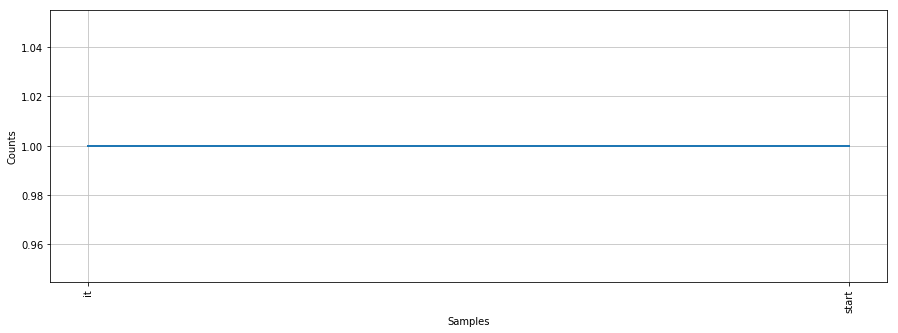

In [30]:
plt.figure(figsize=(15,5))
nltk.FreqDist(dict(sample.iloc[0]['wordcount'].most_common(20))).plot()


### What are the most used words in positive/negative comments?
Using the previously defined methods, it is now possible to observe which words come up the more often in comments classified as either positive or negative.  
As this part is ran locally, the previously generated dataset containing only comments whose author has a flair matching one of the states of the United States of America is used since it is relatively small.

In [31]:
sample_sorted_score = flair_politics.sample(10000).copy().sort_values(by=['score'], ascending=False)
sample_sorted_score['entity'] = sample_sorted_score['body'].apply(nlp_entity)
sample_sorted_score['sentiment'] = sample_sorted_score['body'].apply(nlp_sentiment)
sample_sorted_score['wordcount'] = sample_sorted_score['body'].apply(nlp_wordcount)
sample_sorted_score['label'] = sample_sorted_score['sentiment'].apply(sentiment_to_label)
sample_sorted_score.head()

,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score,entity,sentiment,wordcount,label
6801430,historymajor44,Virginia,That's some tyrant shit,2016-10-10 02:40:04,0,d8lcovs,56psaa,d8lckui,1683,,"-0.5574,0.545,0.455,0.0","{'thats': 1, 'tyrant': 1, 'shit': 1}",Negative
7510318,hearthneewb,Minnesota,ha Hillary up only 4 in the deep blue state of...,2016-10-19 10:51:57,0,d8ykbc7,589lkc,589lkc,1321,"PERSON Hillary,GPE Arizona,GPE Trump,ORGANIZAT...","0.5526,0.0,0.818,0.182","{'ha': 1, 'hillary': 1, 'deep': 1, 'blue': 1, ...",Positive
6818347,ricdesi,Massachusetts,"I disagree.\n\n- - -\n\nCOOPER: ""Does he have ...",2016-10-10 03:46:29,0,d8lftfy,56pqik,d8ld7j2,1010,"ORGANIZATION COOPER,PERSON CLINTON,ORGANIZATIO...","0.3612,0.115,0.705,0.181","{'disagree': 1, 'cooper': 1, 'doe': 1, 'discip...",Positive
6535391,Pvt_Larry,Maryland,And yet they endlessly claim that Clinton will...,2016-10-07 02:15:46,0,d8hcrvq,568wej,d8hcp7d,747,"PERSON Clinton,ORGANIZATION WWIII","0.0,0.0,1.0,0.0","{'and': 1, 'yet': 1, 'endlessly': 1, 'claim': ...",Neutral
7097983,loki8481,New Jersey,the NY Times must be drooling at the prospect ...,2016-10-13 13:50:32,0,d8q84ww,57abxm,57abxm,726,"ORGANIZATION NY Times,PERSON Trump","0.296,0.0,0.896,0.104","{'ny': 1, 'time': 1, 'must': 1, 'drooling': 1,...",Positive


#### Word distribution of comments whose score is higher than a certain threshold

In [50]:
score_threshold = 50
high_score_comments = sample_sorted_score[sample_sorted_score['score'] > score_threshold].copy()

high_score_comments.head()

,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score,entity,sentiment,wordcount,label
6801430,historymajor44,Virginia,That's some tyrant shit,2016-10-10 02:40:04,0,d8lcovs,56psaa,d8lckui,1683,,"-0.5574,0.545,0.455,0.0","{'thats': 1, 'tyrant': 1, 'shit': 1}",Negative
7510318,hearthneewb,Minnesota,ha Hillary up only 4 in the deep blue state of...,2016-10-19 10:51:57,0,d8ykbc7,589lkc,589lkc,1321,"PERSON Hillary,GPE Arizona,GPE Trump,ORGANIZAT...","0.5526,0.0,0.818,0.182","{'ha': 1, 'hillary': 1, 'deep': 1, 'blue': 1, ...",Positive
6818347,ricdesi,Massachusetts,"I disagree.\n\n- - -\n\nCOOPER: ""Does he have ...",2016-10-10 03:46:29,0,d8lftfy,56pqik,d8ld7j2,1010,"ORGANIZATION COOPER,PERSON CLINTON,ORGANIZATIO...","0.3612,0.115,0.705,0.181","{'disagree': 1, 'cooper': 1, 'doe': 1, 'discip...",Positive
6535391,Pvt_Larry,Maryland,And yet they endlessly claim that Clinton will...,2016-10-07 02:15:46,0,d8hcrvq,568wej,d8hcp7d,747,"PERSON Clinton,ORGANIZATION WWIII","0.0,0.0,1.0,0.0","{'and': 1, 'yet': 1, 'endlessly': 1, 'claim': ...",Neutral
7097983,loki8481,New Jersey,the NY Times must be drooling at the prospect ...,2016-10-13 13:50:32,0,d8q84ww,57abxm,57abxm,726,"ORGANIZATION NY Times,PERSON Trump","0.296,0.0,0.896,0.104","{'ny': 1, 'time': 1, 'must': 1, 'drooling': 1,...",Positive


In [41]:
word_positive_high_score = get_word_count(high_score_comments, 'Positive')
word_negative_high_score = get_word_count(high_score_comments, 'Negative')
word_count_high_score = get_word_count(high_score_comments, 'None')

The most common words in comments with a high score deemed positive.

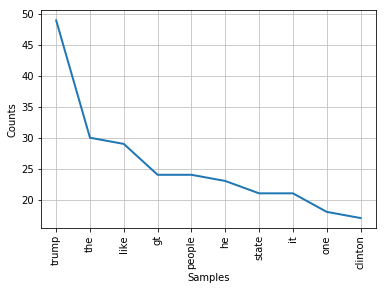

In [52]:
nltk.FreqDist(dict(word_positive_high_score.most_common(10))).plot()

The most common words in comments with a high score deemed negative.

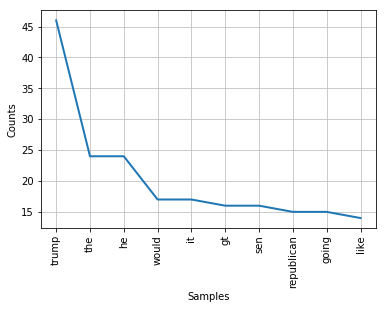

In [53]:
nltk.FreqDist(dict(word_negative_high_score.most_common(10))).plot()

The most common words in comments with a high score.

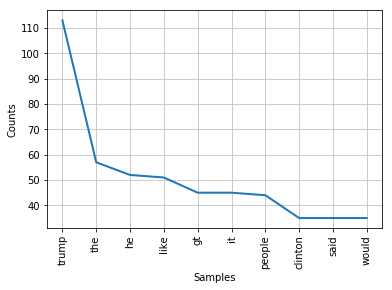

In [54]:
nltk.FreqDist(dict(word_count_high_score.most_common(10))).plot()

#### Word distribution of comments whose score is below 0

In [45]:
low_score_comments = sample_sorted_score[sample_sorted_score['score'] < 0].copy()

low_score_comments.head()

,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score,entity,sentiment,wordcount,label
8114716,oi_rohe,New York,It's a confidential email about how Trump rape...,2016-10-28 18:38:26,0,d9bs6e1,59vuny,d9bqtpp,-1,"PERSON Trump,PERSON Hillary","-0.6808,0.397,0.603,0.0","{'it': 1, 'confidential': 1, 'email': 1, 'trum...",Negative
7619332,Predictor92,New York,"I know that means hand to hand, but the expres...",2016-10-20 03:28:34,0,d8zu8zp,58eh18,d8zu68z,-1,,"0.4939,0.0,0.811,0.189","{'know': 1, 'mean': 1, 'hand': 2, 'expression'...",Positive
6929600,giannini1222,California,"You may not like his political views, but he s...",2016-10-11 05:58:17,0,d8n00m6,56u63b,d8mus3o,-1,,"-0.3784,0.207,0.664,0.129","{'you': 1, 'may': 1, 'like': 1, 'political': 1...",Negative
7473567,SlimLovin,New Jersey,&gt;proof \n\nor\n\n&gt;O'keefe video\n\nPick ...,2016-10-18 20:19:29,0,d8xqmke,584sf4,d8xn3zw,-1,,"0.0,0.0,1.0,0.0","{'gtproof': 1, 'gtokeefe': 1, 'video': 1, 'pic...",Neutral
7445861,kevinS-,Massachusetts,conservatism is objectively better than modern...,2016-10-18 14:22:55,0,d8x81gd,57youd,d8wu72e,-1,ORGANIZATION R,"0.1945,0.17,0.633,0.197","{'conservatism': 1, 'objectively': 1, 'better'...",Neutral


In [46]:
word_positive_low_score = get_word_count(low_score_comments, 'Positive')
word_negative_low_score = get_word_count(low_score_comments, 'Negative')
word_count_low_score = get_word_count(low_score_comments, 'None')

The most common words in comments with a score below 0 deemed positive.

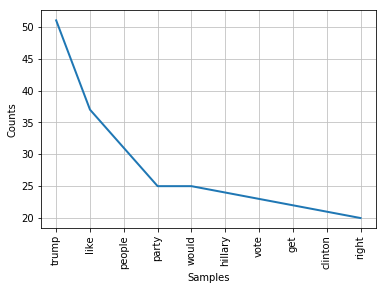

In [55]:
nltk.FreqDist(dict(word_positive_low_score.most_common(10))).plot()

The most common words in comments with a score below 0 deemed negative.

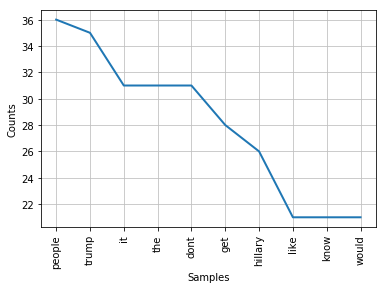

In [56]:
nltk.FreqDist(dict(word_negative_low_score.most_common(10))).plot()

The most common words in comments with a score below 0.

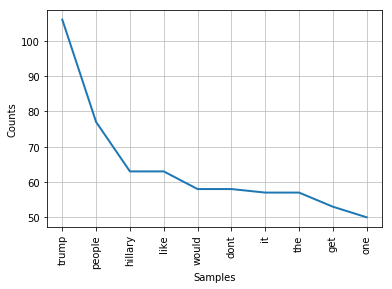

In [57]:
nltk.FreqDist(dict(word_count_low_score.most_common(10))).plot()

#### Comparing high and low score comments
By comparing word frequencies, words that appear only in low/high score comments can be retrieved, as well as words that appear in both type of comments. By low score comments, comments with a score below 0 is meant.

In [92]:
both = nltk.FreqDist()
good_only = nltk.FreqDist()
for word in word_count_high_score:
    if word in word_count_low_score:
        both[word] += word_count_high_score.get(word) + word_count_low_score.get(word)
    else:
        good_only[word] = word_count_high_score.get(word)
        
bad_only = nltk.FreqDist()
for word in word_count_low_score:
    if word not in word_count_high_score:
        bad_only[word] = word_count_low_score.get(word)

The most common words appearing in both low and high score comments.

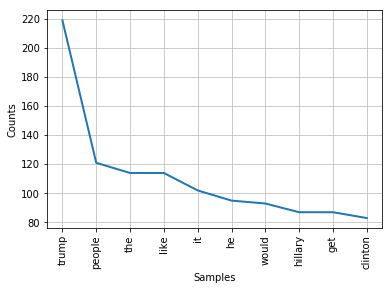

In [93]:
nltk.FreqDist(dict(both.most_common(10))).plot()

The most common words appearing in high score comments.

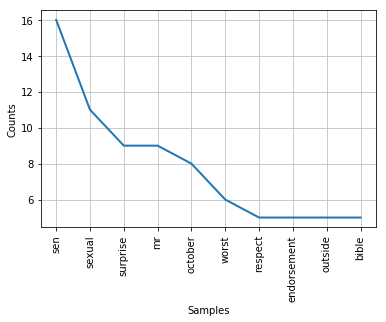

In [94]:
nltk.FreqDist(dict(good_only.most_common(10))).plot()

The most common words appearing in low score comments.

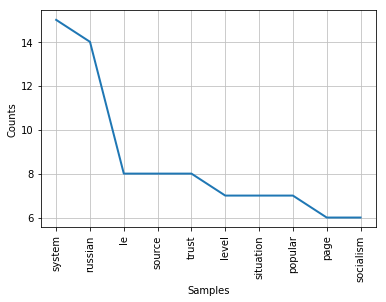

In [95]:
nltk.FreqDist(dict(bad_only.most_common(10))).plot()

## Entities

In [97]:
flair_politics['entity'] = flair_politics['body'].apply(nlp_entity)
flair_politics['sentiment'] = flair_politics['body'].apply(nlp_sentiment)
flair_politics['wordcount'] = flair_politics['body'].apply(nlp_wordcount)
flair_politics['label'] = flair_politics['sentiment'].apply(sentiment_to_label)

/anaconda3/envs/ada/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda3/envs/ada/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda3/envs/ada/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [1]:
flair_politics.to_parquet(DATA_PATH + 'flair_politics.parquet')

NameError: name 'flair_politics' is not defined

In [163]:
flair_politics.head()

,index,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score,entity,sentiment,wordcount,label
6147305,1669459,Qu1nlan,California,Hi `juno255`. Thank you for participating in /...,2016-09-30 02:31:46,0,d87sxgv,5552n9,5552n9,1,"PERSON Title,ORGANIZATION Reddit","0.8738,0.0,0.883,0.117","{'hi': 1, 'juno255': 1, 'thank': 1, 'participa...",Positive
6147372,1669526,Qu1nlan,California,Hi `Alejandro_Last_Name`. Thank you for partic...,2016-09-30 02:33:36,0,d87t05c,5556yb,5556yb,1,"PERSON Title,ORGANIZATION Reddit","0.8738,0.0,0.883,0.117","{'hi': 1, 'alejandrolastname': 1, 'thank': 1, ...",Positive
6147390,1669544,Qu1nlan,California,Hi `ImNotJesus`. Thank you for participating i...,2016-09-30 02:33:57,0,d87t0p2,5548v7,5548v7,1,"ORGANIZATION ImNotJesus,PERSON Title,ORGANIZAT...","0.8738,0.0,0.883,0.117","{'hi': 1, 'imnotjesus': 1, 'thank': 1, 'partic...",Positive
6147458,1669612,Qu1nlan,California,Hi `cmonshoe`. Thank you for participating in ...,2016-09-30 02:35:17,0,d87t2mq,5541x2,5541x2,1,"PERSON Rehosted Content,GPE Video,ORGANIZATION...","0.9163,0.0,0.843,0.157","{'hi': 1, 'cmonshoe': 1, 'thank': 1, 'particip...",Positive
6147507,1669661,Qu1nlan,California,Hi `abourne`. Thank you for participating in /...,2016-09-30 02:36:23,0,d87t4ep,554okj,554okj,1,"PERSON Title,ORGANIZATION Reddit","0.8738,0.0,0.883,0.117","{'hi': 1, 'abourne': 1, 'thank': 1, 'participa...",Positive


In [169]:
#remplacé ancienne methode score par celle ci pour pas faire 2 loops
def get_score(row, candidate1, candidate2, out_states, score= False):
    current_state = row['author_flair_text']
    firstName1=candidate1[0]
    lastName1=candidate1[1]
    firstName2=candidate2[0]
    lastName2=candidate2[1]
    if firstName1 in row['entity'] or lastName1 in row['entity']:
        if row['label'] == 'Positive': 
            if score : 
                out_states.loc[current_state, 'score_'+lastName1] += row['score']
            else :
                out_states.loc[current_state, 'score_'+lastName1] += 1
        elif row['label'] == 'Negative':
            if score : 
                out_states.loc[current_state, 'score_'+lastName1] -= row['score']
            else :
                out_states.loc[current_state, 'score_'+lastName1] -= 1
    
    if firstName2 in row['entity'] or lastName2 in row['entity']:
        if row['label'] == 'Positive':          
            if score : 
                out_states.loc[current_state, 'score_'+lastName2] += row['score']
            else :
                out_states.loc[current_state, 'score_'+lastName2] += 1
        elif row['label'] == 'Negative':
            if score : 
                out_states.loc[current_state, 'score_'+lastName2] -= row['score']
            else :
                out_states.loc[current_state, 'score_'+lastName2] -= 1

In [170]:
def comp_winner(state_df):
    final_score = []
    for state in state_df.index :
        if (state_df.loc[state, 'score_Clinton']>state_df.loc[state, 'score_Trump']):
            #0 if Clinton wins
            final_score.append(0)
        else :
            #1 if Trump wins
            final_score.append(1)
    return final_score

## Scores do not count : 

In [171]:
state_df = states.copy()
state_df.set_index('State', inplace=True)
state_df.head()

,Abbreviation
State,
Alabama,AL
Alaska,AK
Arizona,AZ
Arkansas,AR
California,CA


In [172]:
state_df['score_Trump'] = 0
state_df['score_Clinton'] = 0
candidate1 = ['Donald', 'Trump']
candidate2 = ['Hillary', 'Clinton']

flair_politics.apply(get_score, candidate1=candidate1, candidate2=candidate2, out_states=state_df, axis=1)
state_df['Winner'] = comp_winner(state_df)
state_df.reset_index(inplace = True)
state_df.set_index('Abbreviation', inplace=True)

state_df.head()

,State,score_Trump,score_Clinton,Winner
Abbreviation,,,,
AL,Alabama,9,16,0
AK,Alaska,-26,2,0
AZ,Arizona,-16,-25,1
AR,Arkansas,7,1,1
CA,California,102,189,0


In [143]:
def us_election_colors(state_df, state):
    """Maps Clinton wins to blue and Trump wins to red."""
    clinton_win = state_df.loc[state, 'Winner'] == 0
    if clinton_win:
        return '#0000ff'
    else:
        return '#ff0000'

In [167]:
state_geo_path = DATA_PATH + r'us-states.json'
geo_json_data = json.load(open(state_geo_path))

results_map = folium.Map([43,-100], tiles='cartodbpositron', zoom_start=4)
folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor': us_election_colors(state_df, feature['id']),
        'color' : 'black',
        'weight' : 2,
        'dashArray' : '5, 5'
        }
    ).add_to(results_map)

results_map

In [168]:
results_map.save('US_Election_Prediction_2016.html')

## Scores count :

In [176]:
state_df2 = states.copy()
state_df2.set_index('State', inplace=True)
state_df2['score_Trump'] = 0
state_df2['score_Clinton'] = 0

flair_politics.apply(get_score, candidate1=candidate1, candidate2=candidate2, out_states=state_df2, score=True, axis=1)
state_df2['Winner'] = comp_winner(state_df2)
state_df2.reset_index(inplace = True)
state_df2.set_index('Abbreviation', inplace=True)

state_df2.head()

,State,score_Trump,score_Clinton,Winner
Abbreviation,,,,
AL,Alabama,-557,591,0
AK,Alaska,747,523,1
AZ,Arizona,-151,230,0
AR,Arkansas,-980,-37,0
CA,California,4939,4770,1


In [177]:
results_map_score = folium.Map([43,-100], tiles='cartodbpositron', zoom_start=4)
folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor': us_election_colors(state_df2, feature['id']),
        'color' : 'black',
        'weight' : 2,
        'dashArray' : '5, 5'
        }
    ).add_to(results_map_score)

results_map_score

In [178]:
results_map_score.save('US_Election_Pred_Using_Scores_2016.html')

## Visualizing data

To get a feel for the dataset, a histogram with the number of comments for each day is plotted.

In [37]:
# computation of the number of days the dataset spans
days = (politics.iloc[-1].created_utc - politics.iloc[0].created_utc).days + 1

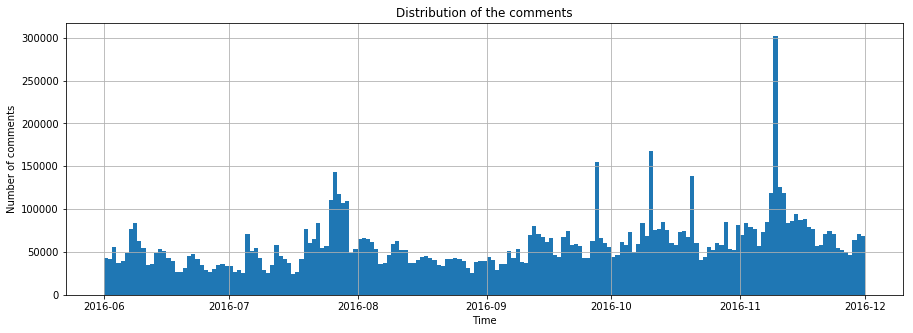

In [38]:
plt.figure(figsize=(15,5))
plt.grid()
plt.hist(politics['created_utc'], bins=days)
plt.ylabel('Number of comments')
plt.xlabel('Time')
plt.title('Distribution of the comments')
plt.show()